Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3884 - val_loss: 0.3848
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3850 - val_loss: 0.3826
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3825 - val_loss: 0.3793
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3786 - val_loss: 0.3728
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3712 - val_loss: 0.3603
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3567 - val_loss: 0.3372
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3304 - val_loss: 0.2974
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2861 - val_loss: 0.2412
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2295 - val_loss: 0.1862
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1752 - val_loss: 0.1347
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1259 - val_loss: 0.0968
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0921 - val_loss: 0.0746
Epoch 1

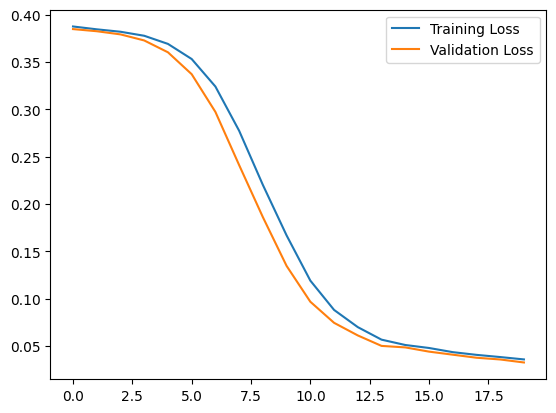

In [63]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load datasets
dataframe_train = pd.read_csv('BATADAL_dataset04.csv')
dataframe_test = pd.read_csv('BATADAL_test_dataset.csv')

# Preprocess data
data = dataframe_train.drop(dataframe_train.columns[[0, -1]], axis=1)  # Remove date and label columns
labels = dataframe_train.iloc[:, -1]  # Classification column
testing_data = dataframe_test.drop(dataframe_test.columns[0], axis=1)  # Remove date column

# Split training data into train/test subsets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

# Normalize training and testing data
min_val = train_data.min().min()
max_val = train_data.max().max()

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
testing_data = (testing_data - min_val) / (max_val - min_val)

# Convert data to TensorFlow tensors
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
testing_data = tf.cast(testing_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Split normal and anomalous data
normal_train_data = train_data.numpy()[train_labels.to_numpy()]
normal_test_data = test_data.numpy()[test_labels.to_numpy()]
anomalous_train_data = train_data.numpy()[~train_labels.to_numpy()]
anomalous_test_data = test_data.numpy()[~test_labels.to_numpy()]

# Define an autoencoder model
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(43, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

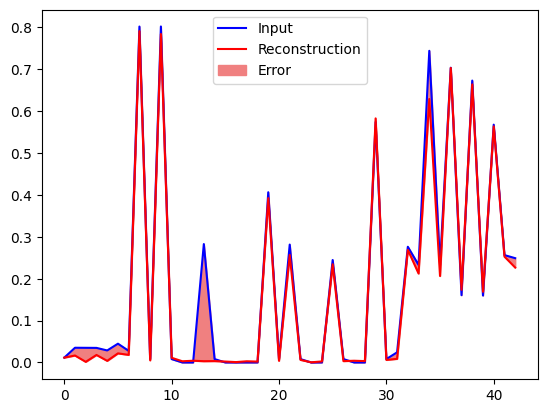

In [64]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(43), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


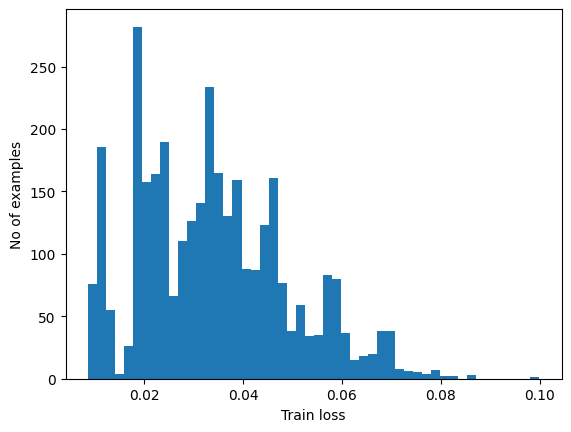

In [65]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [66]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.04940314


In [68]:
# Define a prediction function
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return loss < threshold  # Return boolean predictions

# Make predictions on the test set
test_predictions = predict(autoencoder, normal_test_data, threshold)

# Convert predictions and labels to binary (True/False) values
test_predictions = test_predictions.numpy().astype(int)  # Convert to 1 (True) / 0 (False)
test_labels = test_labels.astype(int)  # Convert to 1 (True) / 0 (False)

# Print the stats
def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

# Print the evaluation metrics
print_stats(test_predictions, test_labels)

Accuracy = 0.8779904306220095
Precision = 1.0
Recall = 0.8779904306220095
